### Load data from Michibiki-1 Magnetometers and create data gap

c:\Users\alexp\anaconda3\lib\site-packages\pymssa\mssa.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


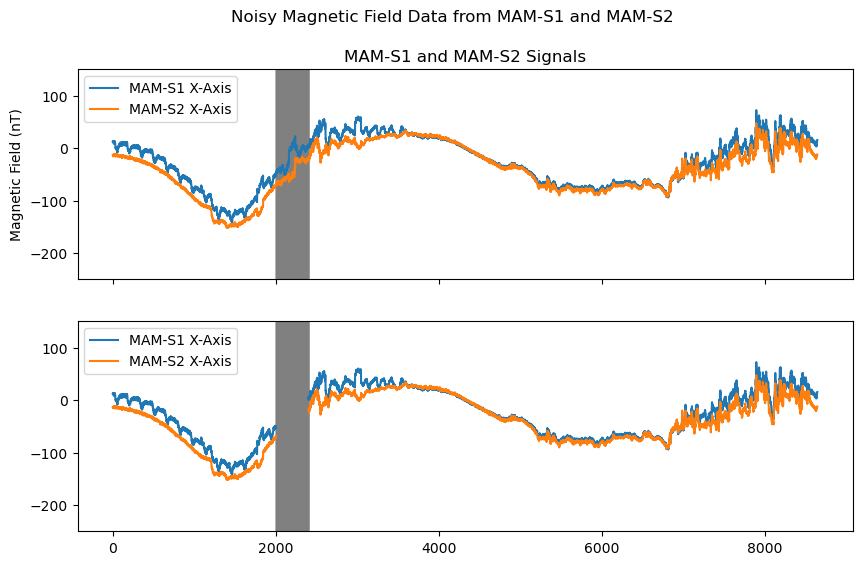

In [1]:
"Import the necessary modules"
from magprime import utility
import numpy as np
import matplotlib.pyplot as plt


B = utility.load_michibiki_data() # shape = (n_sensor, n_axis, n_samples)

"Decimate the data to 0.1 Hz because UBSS and MSSA are slow methods and it will take a long time to run on 86,400 data points"
B_qzs = B[:,:,::10]
B_gap = np.copy(B_qzs); B_gap[:,:,2000:2400] = np.nan
gaps = 1 - np.isnan(B_gap); gaps = gaps[0,0]


"Create a 3 x 2-panel plot of MAM-S1 and MAM-S2 data with overlapping magnetometers in the same panel"
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
fig.suptitle("Noisy Magnetic Field Data from MAM-S1 and MAM-S2")
axs[0].set_title("MAM-S1 and MAM-S2 Signals")
axs[0].plot(B_qzs[0,0], label="MAM-S1 X-Axis")
axs[0].plot(B_qzs[1,0], label="MAM-S2 X-Axis")
axs[0].set_ylabel("Magnetic Field (nT)")
axs[0].set_ylim(-250, 150)
axs[0].legend()


axs[1].plot(B_gap[:,0,:].T, label=["MAM-S1 X-Axis", "MAM-S2 X-Axis"])
axs[1].legend()

# Adding grey areas for gaps
for i, g in enumerate(gaps):
    if g == 0:
        axs[0].axvspan(i, i+1, color='grey', alpha=0.5)
        axs[1].axvspan(i, i+1, color='grey', alpha=0.5)

plt.show()



### Interpolate missing segment

(8640,) (2, 8640)
Constructing trajectory matrix
Trajectory matrix shape: (1596, 1203)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders
Constructing trajectory matrix
Trajectory matrix shape: (1596, 5443)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders


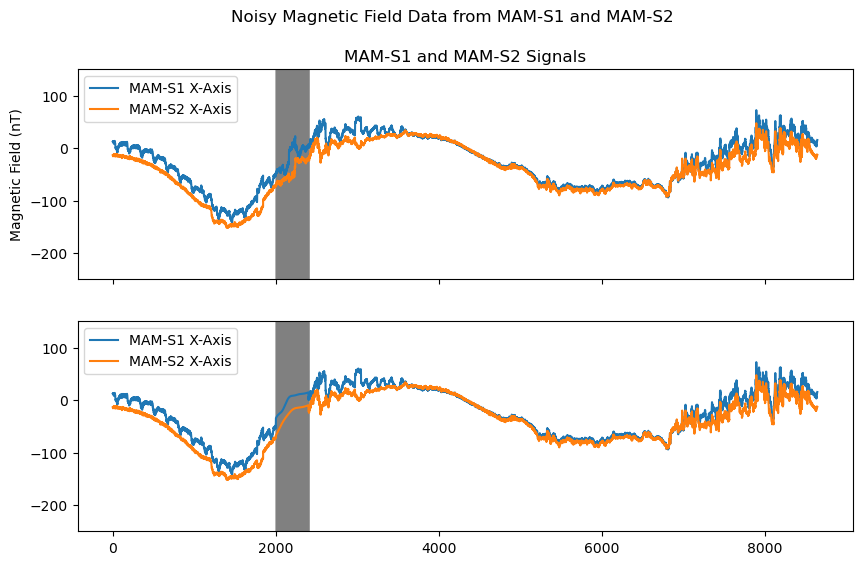

In [13]:
from magprime.utility import interpolation

print(gaps.shape, B_gap[:,0,:].shape)

"Interpolate the data using MSSA forecasting"
interpolation.mssa.verbose = True
interpolation.mssa.n_components = 5
B_interpolated = interpolation.mssa.interpolate(B_gap[:,0,:], gaps, triaxial=False)


"Plot the interpolated data"
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
fig.suptitle("Noisy Magnetic Field Data from MAM-S1 and MAM-S2")
axs[0].set_title("MAM-S1 and MAM-S2 Signals")
axs[0].plot(B_qzs[0,0], label="MAM-S1 X-Axis")
axs[0].plot(B_qzs[1,0], label="MAM-S2 X-Axis")
axs[0].set_ylabel("Magnetic Field (nT)")
axs[0].set_ylim(-250, 150)
axs[0].legend()


axs[1].plot(B_interpolated.T, label=["MAM-S1 X-Axis", "MAM-S2 X-Axis"])
axs[1].legend()

# Adding grey areas for gaps
for i, g in enumerate(gaps):
    if g == 0:
        axs[0].axvspan(i, i+1, color='grey', alpha=0.5)
        axs[1].axvspan(i, i+1, color='grey', alpha=0.5)

plt.show()

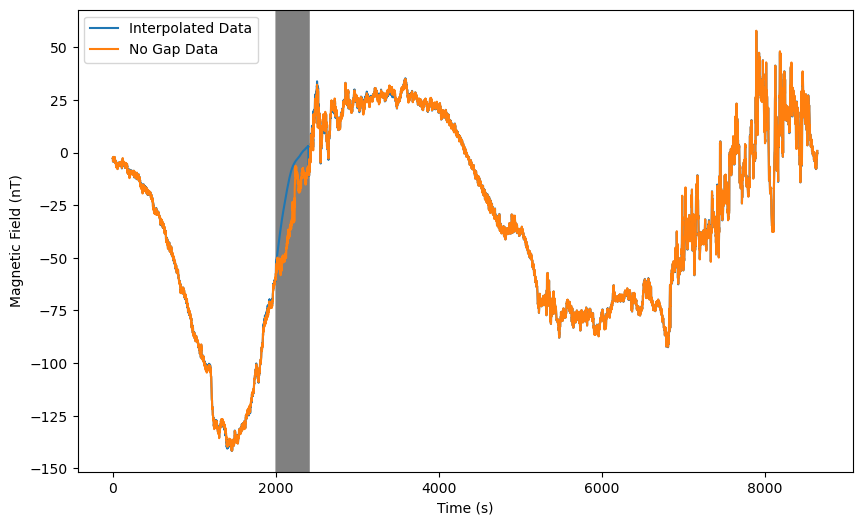

In [16]:
# Remove noise from the interpolated data
from magprime.algorithms import WAICUP

"Detrend the data"
WAICUP.uf = 360
WAICUP.detrend = True

"Algorithm Parameters"
WAICUP.fs = .1

"Clean the data"
B_waicup_interpolated = WAICUP.clean(np.copy(B_interpolated), triaxial=False)
B_waicup = WAICUP.clean(np.copy(B_qzs[:,0,:]), triaxial=False)

"Plot the data"
fig, axs = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
axs.plot(B_waicup_interpolated, label="Interpolated Data")
axs.plot(B_waicup, label="No Gap Data")

plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()
for i, g in enumerate(gaps):
    if g == 0:
        axs.axvspan(i, i+1, color='grey', alpha=0.5)